# RLT Calibration 

#### Import packages

In [26]:
import os
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#### Fill in the directory path

In [24]:
folder = r'U:\Ben\CI Semi\Python scripts\CI\MultiCal\Data\17976' # copy the directory that contains the csv files here
folder = folder + '\\' 
files = sorted(os.listdir(folder))

## Derive calibration parameters

DeLTA17976-46_11DeLTA_Rmaster-02_channel1:
Vinf= 2.25894e+10 
V0= 398.74836 
L1= 1.00180 
L2= 0.05249 

DeLTA17976-46_11DeLTA_Rmaster-02_channel1_old:
Vinf= 1.18343e+10 
V0= 192.91949 
L1= 0.99183 
L2= 0.06875 

DeLTA17976-46_11DeLTA_Rmaster-02_channel2:
Vinf= 2.59261e+10 
V0= 426.64223 
L1= 0.99550 
L2= 0.05829 

DeLTA17976-46_11DeLTA_Rmaster-02_channel2_old:
Vinf= 1.42303e+10 
V0= 248.07525 
L1= 1.00231 
L2= 0.04984 

DeLTA17976-49_11DeLTA_Rmaster-02_channel1:
Vinf= 2.23360e+10 
V0= 382.89380 
L1= 1.00003 
L2= 0.05268 

DeLTA17976-49_11DeLTA_Rmaster-02_channel1_old:
Vinf= 1.25749e+10 
V0= 225.87710 
L1= 1.00752 
L2= 0.04368 

DeLTA17976-49_11DeLTA_Rmaster-02_channel2:
Vinf= 2.08022e+10 
V0= 350.52197 
L1= 0.99676 
L2= 0.05850 

DeLTA17976-49_11DeLTA_Rmaster-02_channel2_old:
Vinf= 1.24399e+10 
V0= 218.05326 
L1= 1.00081 
L2= 0.05385 

DeLTA17976-53_11DeLTA_Rmaster-02_channel1:
Vinf= 2.34051e+10 
V0= 391.10713 
L1= 0.99562 
L2= 0.06046 

DeLTA17976-53_11DeLTA_Rmaster-02_channel1_old:
V

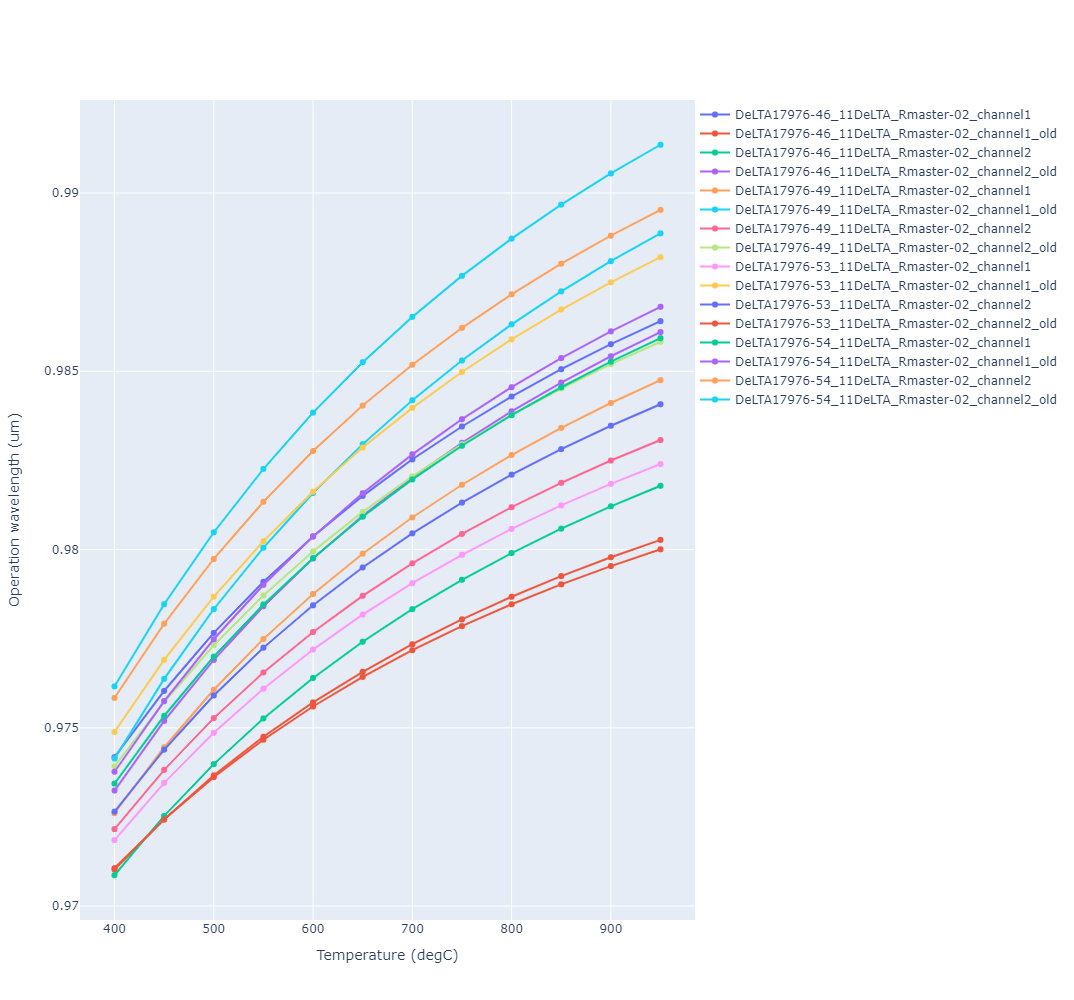

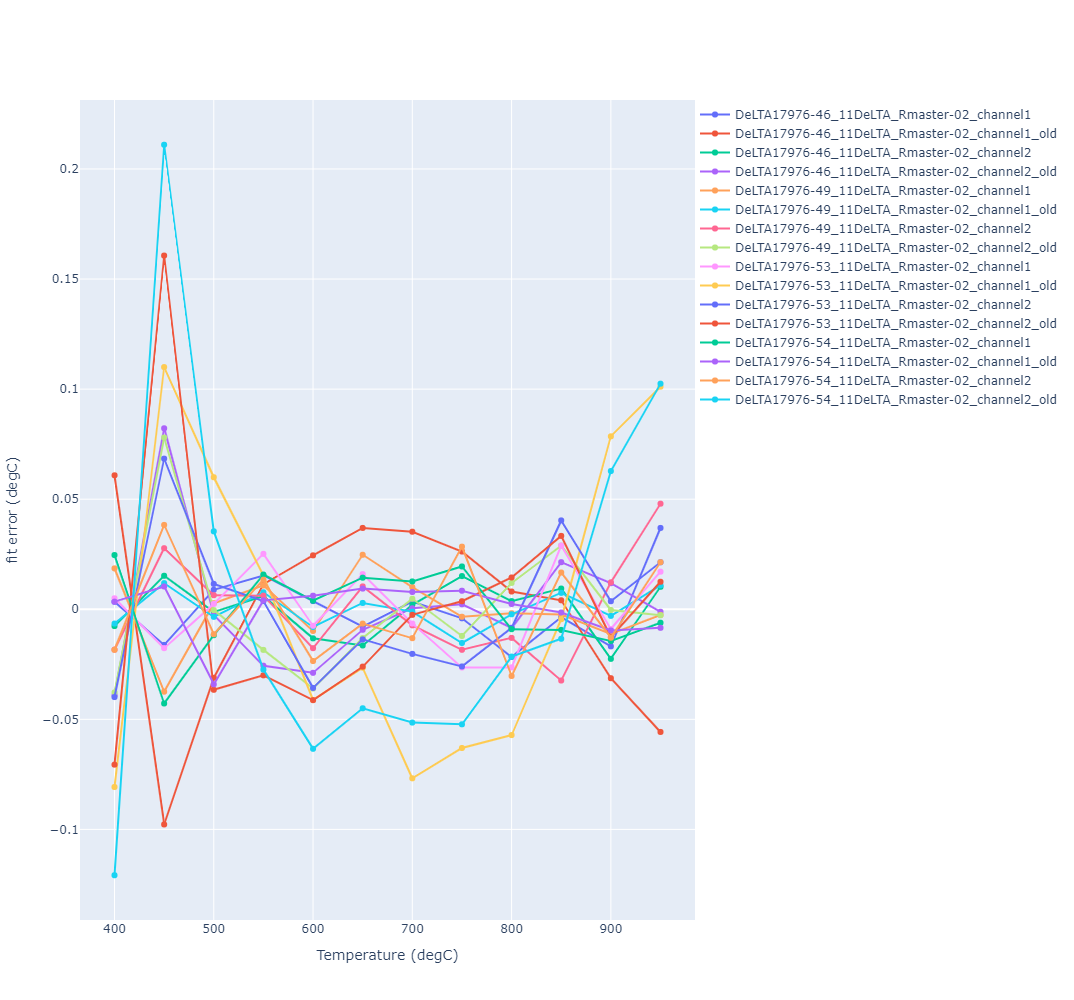

In [25]:
files_arr = []

for f in files:
    if f.endswith(".csv"):
        files_arr.append(str(f)) 
        
dynamicFig1 = make_subplots(specs=[[{"secondary_y": False}]])
dynamicFig2 = make_subplots(specs=[[{"secondary_y": False}]])

C = 14388
T0 = 550

SN = []
Vinf = []
L1 = []
L2 = []
V0 = []


for i in files_arr:
    df = pd.read_csv(folder+i, sep=',', header=0)
    
    Tindices = np.where(df == "Master degC")
    if np.any(Tindices) == False:
        Tcolumn = np.where(df.columns == "Master T")[0][0] 
        Trow = -1
    else:
        Tcolumn = Tindices[1][0] 
        Trow = Tindices[0][0]
        
    Eindices = np.where(df == "UUT emission - Vdoo")
    
    if np.any(Eindices) == False:
        Ecolumn = np.where(df.columns == "Slave E")[0][0]
        Erow = -1
    else:
        Ecolumn = Eindices[1][0] 
        Erow = Eindices[0][0]
    
    T = ((np.array(list(df.iloc[:, Tcolumn][Trow+1:]), dtype=float)))
    E = np.array(list(df.iloc[:, Ecolumn][Erow+1:]), dtype=float)
    
    x = 1/(T+273.15)
    y = np.log(E)
    
    coeffs = np.polyfit(x, y, 2)
    fit = np.poly1d(coeffs)
    
    SN.append(i[:-4])
    Vinf.append(np.exp(coeffs[2]))
    L1.append((-C / coeffs[1]))
    L2.append((-C / coeffs[0]))
    V0.append(Vinf[-1]*np.exp(-C*(1 / (L1[-1]*(T0+273.15)) + 1 / (L2[-1]*(T0+273.15)**2))))
        
    Lambda_eff = 1/(1/L1[-1]+1/(L2[-1]*(T+273.15)))
    FitError = 1/(-0.5*L2[-1]/L1[-1]+L2[-1]*np.sqrt(0.25/(L1[-1])**2-np.log(E/Vinf[-1])/(C*L2[-1])))-273.15-T
    
    # Add traces
    dynamicFig1.add_trace(
        go.Scatter(x=T, y=Lambda_eff, name=SN[-1]),
        secondary_y=False,
    )
    
    # Add traces
    dynamicFig2.add_trace(
        go.Scatter(x=T, y=FitError, name=SN[-1]),  # add for no-line , mode='markers'
        secondary_y=False,
    )
    
    print(SN[-1] + ':')
    print('Vinf=', '{:.5e}'.format(Vinf[-1]),'\nV0=', '{:.5f}'.format(V0[-1]), '\nL1=', '{:.5f}'.format(L1[-1]), '\nL2=', '{:.5f}'.format(L2[-1]), '\n')

print("\nL1 average is: ", np.mean(L1))
print("L1 STD is: ", np.std(L1))
print("\nL2 average is: ", np.mean(L2))
print("L2 STD is: ", np.std(L2))
print("\nV0 average is: ", np.mean(V0))
print("V0 STD is: ", np.std(V0))
print("\nVinf average is: ", '{:.5e}'.format(np.mean(Vinf)))
print("Vinf STD is: ", '{:.5e}'.format(np.std(Vinf)))

dynamicFig1.update_layout(
    autosize=False,
    width=1200,
    height=1000,)

dynamicFig2.update_layout(
    autosize=False,
    width=1200,
    height=1000,)


dynamicFig1.update_xaxes(title_text="Temperature (degC)")
dynamicFig2.update_xaxes(title_text="Temperature (degC)")
dynamicFig1.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.5
))
dynamicFig2.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.5
))

dynamicFig1.update_yaxes(title_text="Operation wavelength (um)", secondary_y=False)
dynamicFig2.update_yaxes(title_text="fit error (degC)", secondary_y=False)
dynamicFig1.update_layout(legend=dict(
    yanchor="top",
    y=1,
    xanchor="left",
    x=1
))
dynamicFig2.update_layout(legend=dict(
    yanchor="top",
    y=1,
    xanchor="left",
    x=1
))

dynamicFig1.show()
dynamicFig2.show()